Problematique : Consumer Complaint Classification

In [43]:
#imports : 
import csv
import re #for RegEx
import pandas as pd
import tensorflow as tf
import numpy as np
import sklearn
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import nltk
#nltk.download('stopwords') #just remove comments if you don't have stopwords
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english')) #i used english ones cuz Dataset is in english

# Load and Viz data & Data pre-processing

Due to the large size of csv file (>1gb), i will read only the first 250k row

In [44]:
#Read the data from CSV file 
df = pd.read_csv('complaints_dataset_full.csv', nrows=250000)
df.info()

C:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 250000 non-null  object
 1   Product                       250000 non-null  object
 2   Sub-product                   245831 non-null  object
 3   Issue                         250000 non-null  object
 4   Sub-issue                     222278 non-null  object
 5   Consumer complaint narrative  66656 non-null   object
 6   Company public response       101835 non-null  object
 7   Company                       250000 non-null  object
 8   State                         247892 non-null  object
 9   ZIP code                      247833 non-null  object
 10  Tags                          25158 non-null   object
 11  Consumer consent provided?    140330 non-null  object
 12  Submitted via                 250000 non-null  object
 13 

In [45]:
df.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    162779
Debt collection                                                                  26062
Mortgage                                                                         15617
Credit card or prepaid card                                                      12964
Checking or savings account                                                      12477
Money transfer, virtual currency, or money service                                4095
Student loan                                                                      3759
Vehicle loan or lease                                                             2937
Credit reporting                                                                  2738
Bank account or service                                                           2119
Payday loan, title loan, or personal loan                                         2116
Credit card                                

In [46]:
df.product

<bound method DataFrame.prod of        Date received                                            Product  \
0         2022-04-28                        Checking or savings account   
1         2022-06-01  Credit reporting, credit repair services, or o...   
2         2022-05-24                                           Mortgage   
3         2022-05-24  Credit reporting, credit repair services, or o...   
4         2022-05-19  Credit reporting, credit repair services, or o...   
...              ...                                                ...   
249995    2019-03-06                                    Debt collection   
249996    2019-03-07  Credit reporting, credit repair services, or o...   
249997    2019-05-17  Credit reporting, credit repair services, or o...   
249998    2019-05-16  Credit reporting, credit repair services, or o...   
249999    2022-02-28  Credit reporting, credit repair services, or o...   

                       Sub-product  \
0                 Checking ac

In [47]:
df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.Product != 'Other financial service']

<AxesSubplot:title={'center':'Number complaints in each product'}>

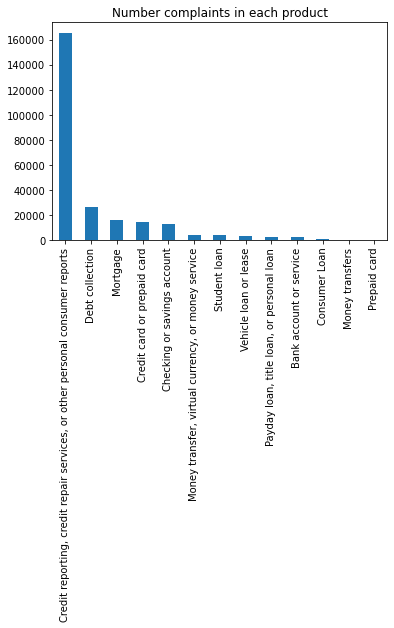

In [48]:
df['Product'].value_counts().sort_values(ascending=False).plot(kind='bar', title='Number complaints in each product')

In [49]:
def print_plot(index):
    example = df[df.index == index][['Consumer complaint narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [50]:
print_plot(100)

I received alerts from XXXX that claimed I had no hard credit inquiries. Alarmed, I contacted XXXX by phone call on XX/XX/2022, since I have not applied, attempted, or requested any new lines of credit with anyone. I found out that a company called XXXX took it upon themselves to ding my credit with hard inquiries for a credit card and an apparent mortgage financing -- despite me never interacting with XXXX. Sure, they send me junk mail that gets shredded & recycled, but that is really not enough to run someone's credit. I tried disputing the information through XXXX 's website. That option was blocked for me on the website with a message that I must call XXXX about disputes. I called XXXX to request a dispute, & an XXXX staff member going by " XXXX '' outright refused to start a dispute. XXXX stated I should contact the company first. I was firm that I most certainly do not need to contact a company that I have never interacted with that is acting in a fraudulent manner. XXXX still re

In [51]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. 
    text = text.replace('x', '')
    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(clean_text)
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].str.replace('\d+', '')


In [52]:
print_plot(100)

ireceivedalertsfromthatclaimedihadnohardcreditinquiriesalarmedicontactedbyphonecallonsinceihavenotappliedattemptedorrequestedanynewlinesofcreditwithanyoneifoundoutthatacompanycalledtookituponthemselvestodingmycreditwithhardinquiriesforacreditcardandanapparentmortgagefinancingdespitemeneverinteractingwithsuretheysendmejunkmailthatgetsshreddedrecycledbutthatisreallynotenoughtorunsomeonescredititrieddisputingtheinformationthroughswebsitethatoptionwasblockedformeonthewebsitewithamessagethatimustcallaboutdisputesicalledtorequestadisputeanstaffmembergoingbyoutrightrefusedtostartadisputestatedishouldcontactthecompanyfirstiwasfirmthatimostcertainlydonotneedtocontactacompanythatihaveneverinteractedwiththatisactinginafraudulentmannerstillrefusedtofileadisputeiinformedthatrefusingtoinitiateadisputeislikelytobeaviolationofthefaircreditreportingactfcrastillrefusedrefusedtogetasupervisorjustleavingmeonrepeatedholdsitappearedtobeawaytoabusemytimecontinuedenyingmyrightstheonlyoptiontheyclaimedthatcoul

In [53]:
# The maximum number of words to be used & Max number of words in each complaint
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 55200 unique tokens.


In [54]:
X = tokenizer.texts_to_sequences(df['Consumer complaint narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (249964, 250)


In [55]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (249964, 13)


# Split the Data

In [56]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(224967, 250) (224967, 13)
(24997, 250) (24997, 13)


# MODEL

In [57]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
3164/3164 [==============================] - 3739s 1s/step - loss: 1.2885 - accuracy: 0.6621 - val_loss: 1.2383 - val_accuracy: 0.6662
Epoch 2/5
3164/3164 [==============================] - 3765s 1s/step - loss: 1.1277 - accuracy: 0.6941 - val_loss: 1.2539 - val_accuracy: 0.6534
Epoch 3/5
3164/3164 [==============================] - 3280s 1s/step - loss: 1.0346 - accuracy: 0.7251 - val_loss: 1.5238 - val_accuracy: 0.5966
Epoch 4/5
3164/3164 [==============================] - 3279s 1s/step - loss: 0.9373 - accuracy: 0.7580 - val_loss: 1.7469 - val_accuracy: 0.5928


# Model Evaluation

In [58]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

782/782 [==============================] - 60s 77ms/step - loss: 1.7587 - accuracy: 0.5903
Test set
  Loss: 1.759
  Accuracy: 0.590


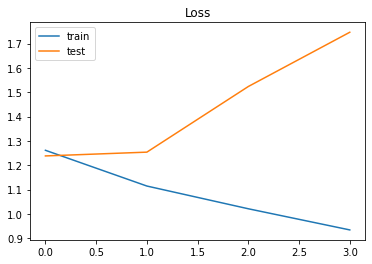

In [59]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

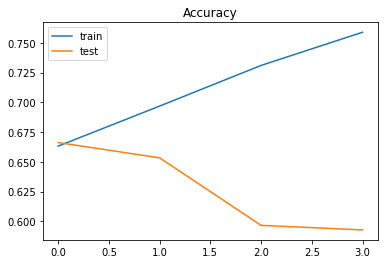

In [60]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# Test

In [62]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of Africa. The following Bank of Africa Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[3.3903199e-03 2.7276661e-02 2.5058975e-02 2.3875542e-01 1.9210611e-05
  4.8007183e-02 9.9567110e-03 5.1473547e-03 4.2500910e-01 8.3637998e-02
  5.3525502e-03 1.5015363e-02 1.1337308e-01]] Payday loan, title loan, or personal loan
